In [3]:
import numpy as np
import pandas as pd 
import cmath 
import scipy.special as sp
import scipy.constants as const
import matplotlib.pyplot as plt

In [4]:
# for TM 
def bessel_roots(m, n): 
    roots = sp.jn_zeros(m, n)
    return roots 

# for TE
def bessel_deriv_roots(m, n):
    roots = sp.jnp_zeros(m, n)
    return roots

In [5]:
testing_J01 = bessel_roots(0,5)
print(testing_J01)

[ 2.40482556  5.52007811  8.65372791 11.79153444 14.93091771]


In [6]:
# test the bessel derivative function

testing_Jd0 = bessel_deriv_roots(0,5)
testing_Jd0

array([ 3.83170597,  7.01558667, 10.17346814, 13.32369194, 16.47063005])

okay those are correct! (based on ones listed in Jackson) 
now going to calculate for TM mode of interest:

In [7]:
# all of the TM modes we're interested in are at n = 1, p = 0
m = 9
n = 1

J91 = bessel_roots(9,5)[0]
J91

13.35430047743533

In [8]:
J10_1 = bessel_roots(10,1)[0]
J10_1

14.475500686554541

In [9]:
J81 = bessel_roots(8,5)[0]
J81

12.225092264004655

#### First: Verify single TM mode. 

Equation: 

$$ 
\omega_{m,n,p} = \frac{c}{\sqrt{\mu\epsilon}} \sqrt{\frac{x_{m,n}^2}{R^2} + \frac{p^2 \pi^2}{d^2}}
$$

note: this is not the most recent equation (1 in numerator of prefactor instead of c), but since I used correct formulation for mu and epsilon (presumably) then my calculations still worked out okay. (if i used the 1 instead of c, i think i would need to use relative permittivity...)
oh. this was the whole problem i was having when i was calculating permittivity before entering it (refer to ipad.)

makes sense. 

In [10]:
c = const.c
mu = 1 
epsilon = 9.6 # just the delectric constant here (equation description Jackson p241)
x_mn = J10_1
p = 0 # because TM 
d = 0.0254 # [meters], 1 inch thick
R = 0.0762 # [meters], 3 inch radius

omega_mnp = (c/np.sqrt(mu*epsilon))*(np.sqrt((x_mn**2/R**2) + (p**2*np.pi**2)/d**2))
omega_mnp

18380770364.75798

In [11]:
def omega_mnp(x_mn, mu = 1, epsilon = 9.6, p = 0, d = 0.0254, R = 0.0762):
    omega = (c/np.sqrt(mu*epsilon)) * (np.sqrt(((x_mn**2)/(R**2)) + (p**2*np.pi**2)/d**2))
    return omega

def omega_mnp_freq_GHz_solver(omega):
    freq = omega/(2*np.pi)
    freq_GHz = freq/(10**9)
    return freq_GHz

In [12]:
def freq_solver_omega_GHz(x_mn, mu = 1, epsilon = 9.6, p = 0, d = 0.0254, R = 0.0762):
    omega = (c/np.sqrt(mu*epsilon)) * (np.sqrt(((x_mn**2)/(R**2)) + (p**2*np.pi**2)/d**2))
    freq = omega/(2*np.pi) # Hz
    freq_GHz = freq/(10**9) # GHz
    return freq_GHz

def bessel_freq_solver_omega_GHz(m, n, mu = 1, epsilon = 9.6, p = 0, d = 0.0254, R = 0.0762):
    X_mn = bessel_deriv_roots(m, n)[0]
    omega = (c/np.sqrt(mu*epsilon)) * (np.sqrt(((X_mn**2)/(R**2)) + (p**2*np.pi**2)/d**2))
    freq = omega/(2*np.pi) # Hz
    freq_GHz = freq/(10**9) # GHz
    return freq_GHz

In [13]:
X_mn = bessel_deriv_roots(10, 5)
X_mn

array([11.77087667, 16.44785275, 20.22303141, 23.76071586, 27.18202153])

In [14]:
X_mn = bessel_deriv_roots(10, 1)
X_mn[0]

11.770876674955582

Trying for TE mode, 3.2028 GHz: 
- \# of lobes = 20, m = 10

In [15]:
X_mn = bessel_deriv_roots(10, 1)[0]

test_TE_3p2028GHz = freq_solver_omega_GHz(X_mn, mu=1, epsilon=9.6, p = 1, d=0.0254, R=0.0762)
test_TE_3p2028GHz

3.0473781978750827

In [16]:
bessel_freq_solver_omega_GHz(10, 1, mu=1, epsilon=9.6, p=1, d=0.0254, R=0.0762)

3.0473781978750827

OKAY interesting – that is not the frequency I am looking for, but it is very close to the next related TM mode, which occurs at 3.0775 + 3.3228e-5i. In that, though, I am using the roots of the derivative of the Bessel function $J_m'(x) = 0$, specifically for TE modes. Which makes it weird that this equation would predict a TE mode here that is super close to where COMSOL finds the TM mode. 

Trying for TE mode, 3.4197 GHz: 
- \# of lobes = 22, 22/2 = 11, 11 + 1 = 12 (m = 12)

In [17]:
X_mn_2 = bessel_deriv_roots(12, 1)[0]

test_TE_3p4197GHz = freq_solver_omega_GHz(X_mn_2, mu=1, epsilon=9.6, p = 1, d=0.0254, R=0.0762)
test_TE_3p4197GHz

3.390391801439172

Okay, interesting again. This is spitting out a frequency arguably closest to the TE mode I was trying to find above. It's missing it by 1. Does this have to do with the lobe counting? I'm dividing by 2 but should I be subtracting by 1 before I do that? I kept seeing online p = l-m. Does that have something to do with it? 

NEVER MIND!!!!
Okay. m as an integer starts at 0, right? So I need to be subtracting 1 or adding 1? Yeah. Because if m = 0 has just a ring, then m = 1 has two rings, m = 2 is three rings. 

Upon reading online, it seems this is true. I needed to be adding 1 to the number I get after dividing \# of lobes by 2!!! 

In [40]:
# function to do whole thing

def bessel_omega_freq_solver(mode_kind, num_lobes, p_TE=1): 
    # define constants
    m = int(num_lobes // 2)
    mu = 1 
    epsilon = 9.6
    d = 0.0254 
    R = 0.0762
    N = 1 # how many roots want of bessel 
    n= 0 #1st root of bessel

    if mode_kind == 'TM': # solve bessel and define p for transverse magnetic (TM)
        x_mn = bessel_roots(m,N)[n]
        p = 0
    if mode_kind == 'TE': # solve bessel and define p for transverse electric (TE) 
        x_mn = bessel_deriv_roots(m,N)[n]
        p = p_TE

    # calculate omega_mnp
    omega_mnp = (c/np.sqrt(mu*epsilon)) * (np.sqrt(((x_mn**2)/(R**2)) + (p**2*np.pi**2)/d**2))
    freq = omega_mnp/(2*np.pi) # Hz
    freq_GHz = freq/(10**9) # GHz

    return freq_GHz


In [28]:
testing = bessel_omega_freq_solver(mode_kind='TE', num_lobes=16)
testing

2.7544653405232715

In [ ]:
0: 1
1: 2
3: 

okay for m(0), there is "1" lobe. so for this, m does not equal (# of lobes)/2. 
for m(0), 

In [41]:
def get_TE_TM_m_p(N_m, p_TE=1): 
    m_array = []
    TM_freqs = []
    TE_freqs = []
    for i in range(0, N_m): 
        TM_freq = bessel_omega_freq_solver('TM', num_lobes = i*2)
        TE_freq = bessel_omega_freq_solver('TE', num_lobes = i*2, p_TE=p_TE)
        m_array.append(i)
        TM_freqs.append(TM_freq)
        TE_freqs.append(TE_freq)
    eigenfreqs = {'m': m_array, 'TE': TE_freqs, 'TM': TM_freqs}
    eigen_m_table = pd.DataFrame(eigenfreqs)
    return eigen_m_table

In [42]:
get_TE_TM_m_p(26, p_TE=2)

,m,TE,TM
0,0,4.064644,1.115567
1,1,3.958796,1.417798
2,2,4.043255,1.701062
3,3,4.139444,1.972630
4,4,4.246197,2.236095
5,5,4.362453,2.493540
6,6,4.487248,2.746294
7,7,4.619715,2.995268
8,8,4.759069,3.241114
9,9,4.904607,3.484322


In [43]:
get_TE_TM_m_p(30, p_TE=1)

,m,TE,TM
0,0,2.374436,1.115567
1,1,2.188306,1.417798
2,2,2.337632,1.701062
3,3,2.500322,1.972630
4,4,2.673351,2.236095
5,5,2.854402,2.493540
6,6,3.041712,2.746294
7,7,3.233942,2.995268
8,8,3.430066,3.241114
9,9,3.629296,3.484322


Next: 
- try to get it to predict all WGMs
- download spreadsheets into (new?) notebook and start looking at TM/TE spacing.

m_arr = np.arange()

In [17]:

ms = []
freqs = []
for i in range(0,50):
    freq = bessel_omega_freq_solver('TE', i-1)
    ms.append(i)
    freqs.append(freq)
TE_eigenfreqs = {'m':ms,'eigenfreq': freqs}

ms = []
freqs = []
for i in range(0,50):
    freq = bessel_omega_freq_solver('TM', i-1)
    ms.append(i)
    freqs.append(freq)
TM_eigenfreqs = {'m':ms,'eigenfreq': freqs}

# TE_eigenfreqs=[]
# for i in range(0,25):
#     freq = bessel_omega_freq_solver('TE', i)
#     TE_eigenfreqs.append([i+1, freq])

# TM_eigenfreqs=[]
# for i in range(0,25):
#     freq = bessel_omega_freq_solver('TM', i-1)
#     TM_eigenfreqs.append([i, freq])

In [21]:
ms_p = []
freqs_p = []
for i in range(0,50):
    freq = bessel_omega_freq_solver('TE', i-1, p_TE=2)
    ms_p.append(i)
    freqs_p.append(freq)
TE_eigenfreqs_p2 = {'m':ms_p,'eigenfreq': freqs_p}

TE_eigenfreqs_p2_table = pd.DataFrame(TE_eigenfreqs_p2)

In [22]:
TE_eigenfreqs_p2_table

,m,eigenfreq
0,0,3.887263
1,1,3.827484
2,2,3.859037
3,3,3.902823
4,4,3.958033
5,5,4.023955
6,6,4.099913
7,7,4.185243
8,8,4.279299
9,9,4.381451


In [23]:
TE_eigenfreqs

{'m': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'eigenfreq': [2.0560708028431076,
  1.9406817526072309,
  2.00219339426076,
  2.0853405276094903,
  2.186925087048155,
  2.3040902909382135,
  2.434316925659605,
  2.5754368491283577,
  2.725621976688559,
  2.8833529606570996,
  3.0473781978750827,
  3.2166713210237456,
  3.390391801439172,
  3.5678506641862033,
  3.748481750614231,
  3.9318181717389664,
  4.117473273276432,
  4.305125362574945,
  4.494505496442386,
  4.685387723753874,
  4.877581280754643,
  5.070924333416409,
  5.265278943930094,
  5.460527006436703,
  5.65656695166352,
  5.85331106326963,
  6.050683282518115,
  6.248617404278727,
  6.44705558791789,
  6.645947122642643,
  6.845247399352356,
  7.044917050813057,
  7.244921229

In [24]:
TM_eigenfreqs

{'m': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'eigenfreq': [0.48599726531879867,
  0.7743591284894963,
  1.0378708702664887,
  1.2893830173200957,
  1.5335472710981521,
  1.7726512984289928,
  2.0080134466405055,
  2.2404724926609587,
  2.4705997445690344,
  2.6988042818780404,
  2.9253904613882526,
  3.1505916985684,
  3.374591465684473,
  3.597536950470012,
  3.8195482788259176,
  4.04072494015239,
  4.261150384485854,
  4.480895387842756,
  4.700020565452168,
  4.918578281809219,
  5.136614125017034,
  5.35416806067336,
  5.571275346247156,
  5.7879672638345,
  6.004271713376716,
  6.2202136973896005,
  6.4358157204227044,
  6.651098120827662,
  6.866079348295983,
  7.080776197581191,
  7.295204006541633,
  7.509376824917376,
  7.723307

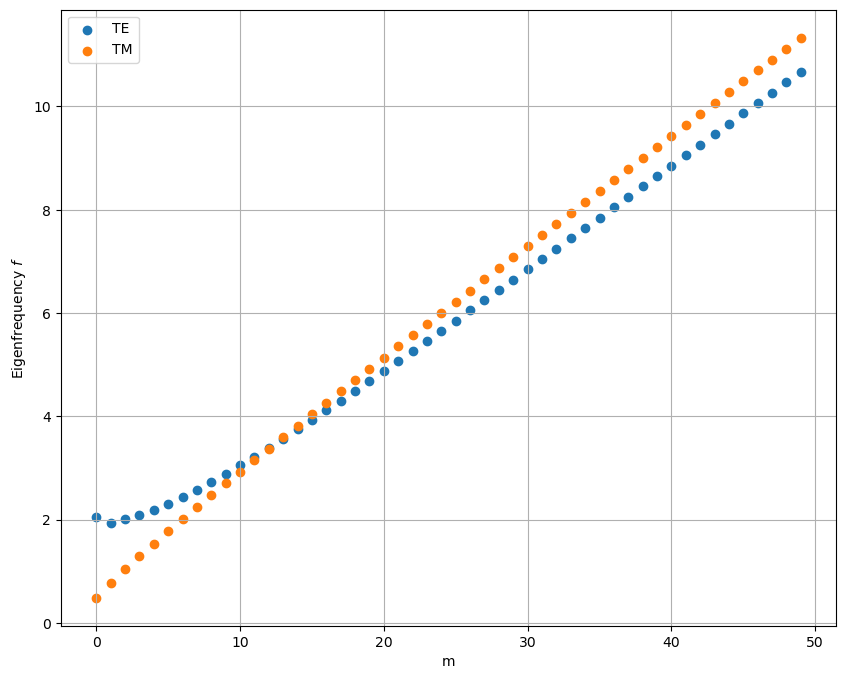

In [25]:
plt.figure(figsize = (10,8))

plt.scatter(TE_eigenfreqs['m'], TE_eigenfreqs['eigenfreq'], label='TE')
plt.scatter(TM_eigenfreqs['m'], TM_eigenfreqs['eigenfreq'], label = 'TM')
plt.xlabel('m')
plt.ylabel('Eigenfrequency $f$')
plt.grid(True)
plt.legend()

In [26]:
# spacing predicted by formula
TE_freq_arr = np.array(TE_eigenfreqs['eigenfreq'])
TM_freq_arr = np.array(TM_eigenfreqs['eigenfreq'])

spacing = TE_freq_arr - TM_freq_arr

In [27]:
spacing

array([ 1.57007354,  1.16632262,  0.96432252,  0.79595751,  0.65337782,
        0.53143899,  0.42630348,  0.33496436,  0.25502223,  0.18454868,
        0.12198774,  0.06607962,  0.01580034, -0.02968629, -0.07106653,
       -0.10890677, -0.14367711, -0.17577003, -0.20551507, -0.23319056,
       -0.25903284, -0.28324373, -0.3059964 , -0.32744026, -0.34770476,
       -0.36690263, -0.38513244, -0.40248072, -0.41902376, -0.43482907,
       -0.44995661, -0.46445977, -0.47838633, -0.4917791 , -0.50467659,
       -0.51711356, -0.52912141, -0.54072864, -0.55196115, -0.56284254,
       -0.57339434, -0.58363629, -0.59358646, -0.60326148, -0.61267666,
       -0.62184609, -0.63078283, -0.63949894, -0.64800562, -0.65631326])

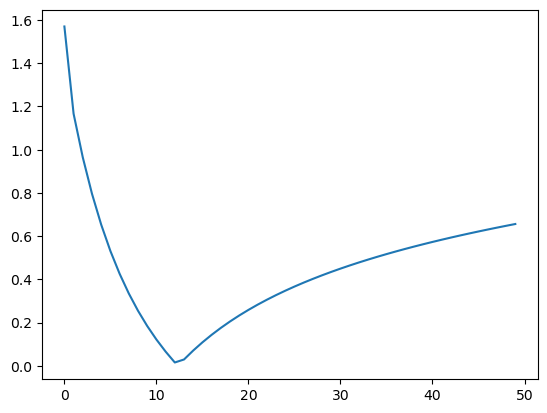

In [28]:
plt.plot(np.abs(spacing))

In [29]:
pd.DataFrame?

Init signature:
pd.DataFrame(
    data=None,
    index: 'Axes | None' = None,
    columns: 'Axes | None' = None,
    dtype: 'Dtype | None' = None,
    copy: 'bool | None' = None,
) -> 'None'
Docstring:     
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order. If a dict contains Series
    which have an index defined, it is aligned by its index. This alignment also
    occurs if data is a Series or a DataFrame itself. Alignment is done on
    Series/DataFrame inputs.

    If data is a list of dicts, column order follows 

In [30]:
wgm_data = {'m': TM_eigenfreqs['m'], 'TE': TE_eigenfreqs['eigenfreq'], 'TM': TM_eigenfreqs['eigenfreq']}

In [31]:
WGM_m_table = pd.DataFrame(wgm_data)

In [32]:
WGM_m_table

,m,TE,TM
0,0,2.056071,0.485997
1,1,1.940682,0.774359
2,2,2.002193,1.037871
3,3,2.085341,1.289383
4,4,2.186925,1.533547
5,5,2.304090,1.772651
6,6,2.434317,2.008013
7,7,2.575437,2.240472
8,8,2.725622,2.470600
9,9,2.883353,2.698804


Curious: 
- why would the highest Q occur where the TE and TM modes are occurring right next to each other in the frequency space? 